In [1]:
import pandas as pd
from db_utils import RDSDatabaseConnector 
from transform_data import DataTransform
from get_information import DataFrameInfo
import missingno as msno
from plotter import Plotter

In [2]:
credentials = RDSDatabaseConnector.yaml_creds_loader()
database = RDSDatabaseConnector(credentials)
database.save_df_to_csv()

In [3]:
df = pd.read_csv('loan_payments.csv')
pd.set_option('display.max_columns', None)
df

,Unnamed: 0,id,member_id,loan_amount,funded_amount,funded_amount_inv,term,int_rate,instalment,grade,sub_grade,employment_length,home_ownership,annual_inc,verification_status,issue_date,loan_status,payment_plan,purpose,dti,delinq_2yrs,earliest_credit_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_accounts,total_accounts,out_prncp,out_prncp_inv,total_payment,total_payment_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_payment_date,last_payment_amount,next_payment_date,last_credit_pull_date,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type
0,0,38676116,41461848,8000,8000.0,8000.0,36 months,7.49,248.82,A,A4,5 years,MORTGAGE,46000.0,Not Verified,Jan-2021,Current,n,credit_card,19.54,2,Oct-1987,1,5.0,NaN,12,27,5529.70,5529.70,2982.51,2982.51,2470.30,512.21,0.000000,0.00,0.00,Jan-2022,248.82,Feb-2022,Jan-2022,0.0,5.0,1,INDIVIDUAL
1,1,38656203,41440010,13200,13200.0,13200.0,36 months,6.99,407.52,A,A3,9 years,RENT,50000.0,Not Verified,Jan-2021,Current,n,credit_card,24.20,0,Sep-2001,0,NaN,NaN,15,31,9102.83,9102.83,4885.11,4885.11,4097.17,787.94,0.000000,0.00,0.00,Jan-2022,407.52,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
2,2,38656154,41439961,16000,16000.0,16000.0,36 months,7.49,497.63,A,A4,8 years,MORTGAGE,73913.0,Source Verified,Jan-2021,Fully Paid,n,credit_card,16.92,0,Sep-1998,0,69.0,NaN,7,18,0.00,0.00,16824.54,16824.54,16000.00,824.54,0.000000,0.00,0.00,Oct-2021,12850.16,NaN,Oct-2021,0.0,NaN,1,INDIVIDUAL
3,3,38656128,41439934,15000,15000.0,15000.0,36 months,14.31,514.93,C,C4,1 year,RENT,42000.0,Source Verified,Jan-2021,Fully Paid,n,debt_consolidation,35.52,0,Jun-2008,0,74.0,NaN,6,13,0.00,0.00,15947.47,15947.47,15000.00,947.47,0.000000,0.00,0.00,Jun-2021,13899.67,NaN,Jun-2021,0.0,NaN,1,INDIVIDUAL
4,4,38656121,41439927,15000,15000.0,15000.0,36 months,6.03,456.54,A,A1,10+ years,MORTGAGE,145000.0,Verified,Jan-2021,Current,n,debt_consolidation,3.33,0,Apr-2002,1,37.0,NaN,23,50,10297.47,10297.47,5473.46,5473.46,4702.53,770.93,0.000000,0.00,0.00,Jan-2022,456.54,Feb-2022,Jan-2022,0.0,NaN,1,INDIVIDUAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54226,54226,76597,76583,5000,5000.0,1775.0,36 months,9.01,159.03,B,B2,1 year,MORTGAGE,250000.0,Not Verified,Jul-2013,Fully Paid,n,other,10.00,2,Apr-2003,0,5.0,NaN,5,7,0.00,0.00,5724.82,2032.29,5000.00,724.82,0.000000,0.00,0.00,Jul-2016,160.61,NaN,Jul-2016,NaN,NaN,1,INDIVIDUAL
54227,54227,142608,74724,5000,5000.0,2350.0,36 months,10.59,162.73,C,C2,< 1 year,RENT,15000.0,Not Verified,Oct-2013,Fully Paid,n,other,24.40,0,Jan-1999,3,0.0,0.0,6,6,0.00,0.00,5931.25,2787.47,5000.00,826.31,104.942381,0.00,0.00,Oct-2016,490.01,NaN,Sep-2016,0.0,NaN,1,INDIVIDUAL
54228,54228,117045,70978,3500,3500.0,2225.0,36 months,7.43,108.77,A,A2,10+ years,MORTGAGE,300000.0,Not Verified,Aug-2013,Does not meet the credit policy. Status:Fully ...,n,debt_consolidation,1.00,0,Feb-1984,0,NaN,NaN,8,18,0.00,0.00,3915.37,2489.01,3500.00,415.37,0.000000,0.00,0.00,Sep-2016,110.58,Sep-2016,May-2013,NaN,NaN,1,INDIVIDUAL
54229,54229,88854,70699,5000,5000.0,225.0,36 months,7.43,155.38,A,A2,4 years,RENT,200000.0,Not Verified,Aug-2013,Fully Paid,n,house,0.28,0,Mar-1995,0,0.0,0.0,2,2,0.00,0.00,5174.18,232.84,5000.00,174.18,0.000000,0.00,0.00,Mar-2014,0.00,NaN,May-2013,NaN,NaN,1,INDIVIDUAL


# Converting Column Datatypes
a lot of these columns are not formatted to the correct dtype which you can see from the df.info() below. To remedy this I will convert a lot of these columns which can be formatted correctly using my transform_data module

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54231 entries, 0 to 54230
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   54231 non-null  int64  
 1   id                           54231 non-null  int64  
 2   member_id                    54231 non-null  int64  
 3   loan_amount                  54231 non-null  int64  
 4   funded_amount                51224 non-null  float64
 5   funded_amount_inv            54231 non-null  float64
 6   term                         49459 non-null  object 
 7   int_rate                     49062 non-null  float64
 8   instalment                   54231 non-null  float64
 9   grade                        54231 non-null  object 
 10  sub_grade                    54231 non-null  object 
 11  employment_length            52113 non-null  object 
 12  home_ownership               54231 non-null  object 
 13  annual_inc      

In [5]:
DataTransform.convert_columns(df)

# Dataframe information
in this segment I will be looking into the dataframe itself and try and generate useful information about the DataFrame

In [6]:
DataFrameInfo.datatypes(df)

Unnamed: 0                              int64
id                                      int64
member_id                               int64
loan_amount                             int64
funded_amount                         float64
funded_amount_inv                     float64
term                                   object
int_rate                              float64
instalment                            float64
grade                                category
sub_grade                            category
employment_length                      object
home_ownership                       category
annual_inc                            float64
verification_status                  category
issue_date                     datetime64[ns]
loan_status                          category
payment_plan                             bool
purpose                              category
dti                                   float64
delinq_2yrs                             int64
earliest_credit_line           dat

In [7]:
DataFrameInfo.statistics(df)

,count,mean,min,25%,50%,75%,max,std
Unnamed: 0,54231.0,27115.0,0.0,13557.5,27115.0,40672.5,54230.0,15655.285561
id,54231.0,7621797.476277,55521.0,759433.0,7084590.0,8860616.5,38676116.0,9571361.647372
member_id,54231.0,8655349.927993,70694.0,958772.0,8709873.0,10527137.0,41461848.0,10312806.882093
loan_amount,54231.0,13333.0761,500.0,7000.0,12000.0,18000.0,35000.0,8082.196709
funded_amount,51224.0,13229.509117,500.0,7000.0,12000.0,18000.0,35000.0,8019.017599
funded_amount_inv,54231.0,12952.622979,0.0,6700.0,11300.0,18000.0,35000.0,8099.473527
int_rate,49062.0,13.507328,5.42,10.37,13.16,16.2,26.06,4.392893
instalment,54231.0,400.013953,15.67,224.205,347.15,527.55,1407.01,238.920012
annual_inc,54231.0,72220.848249,3300.0,45000.0,61000.0,86000.0,2039784.0,51589.339577
issue_date,54231,2018-09-17 11:41:04.855894272,2013-06-01 00:00:00,2017-05-01 00:00:00,2019-09-01 00:00:00,2019-11-01 00:00:00,2021-01-01 00:00:00,NaN


In [8]:
DataFrameInfo.percent_null(df)

Unnamed: 0                      0.000000
id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term                            8.799395
int_rate                        9.531449
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
employment_length               3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_

# Dropping Columns
---
### Null values >= 50%
All the columns with >= 50% null values will be dropped as they will introduce too much noise which will not help with analysis.
These Columns include: **mths_since_last_delinq,** **mths_since_last_record**, **next_payment_date** and **mths_since_last_major_derog**

---

We can see **Unnamed: 0** column is equal to the id, so we can safely drop this column and just refer to the id.

---
### Static Value.

The policy_code column is just filled with 1, as this column will not contribute to any findings we can safely drop this column.




In [9]:
DataTransform.drop_columns(df, ['mths_since_last_delinq', 'mths_since_last_record', 'next_payment_date', 'mths_since_last_major_derog'])
DataTransform.drop_columns(df, ['Unnamed: 0', 'policy_code'])
df.shape

(54231, 38)

<Axes: >

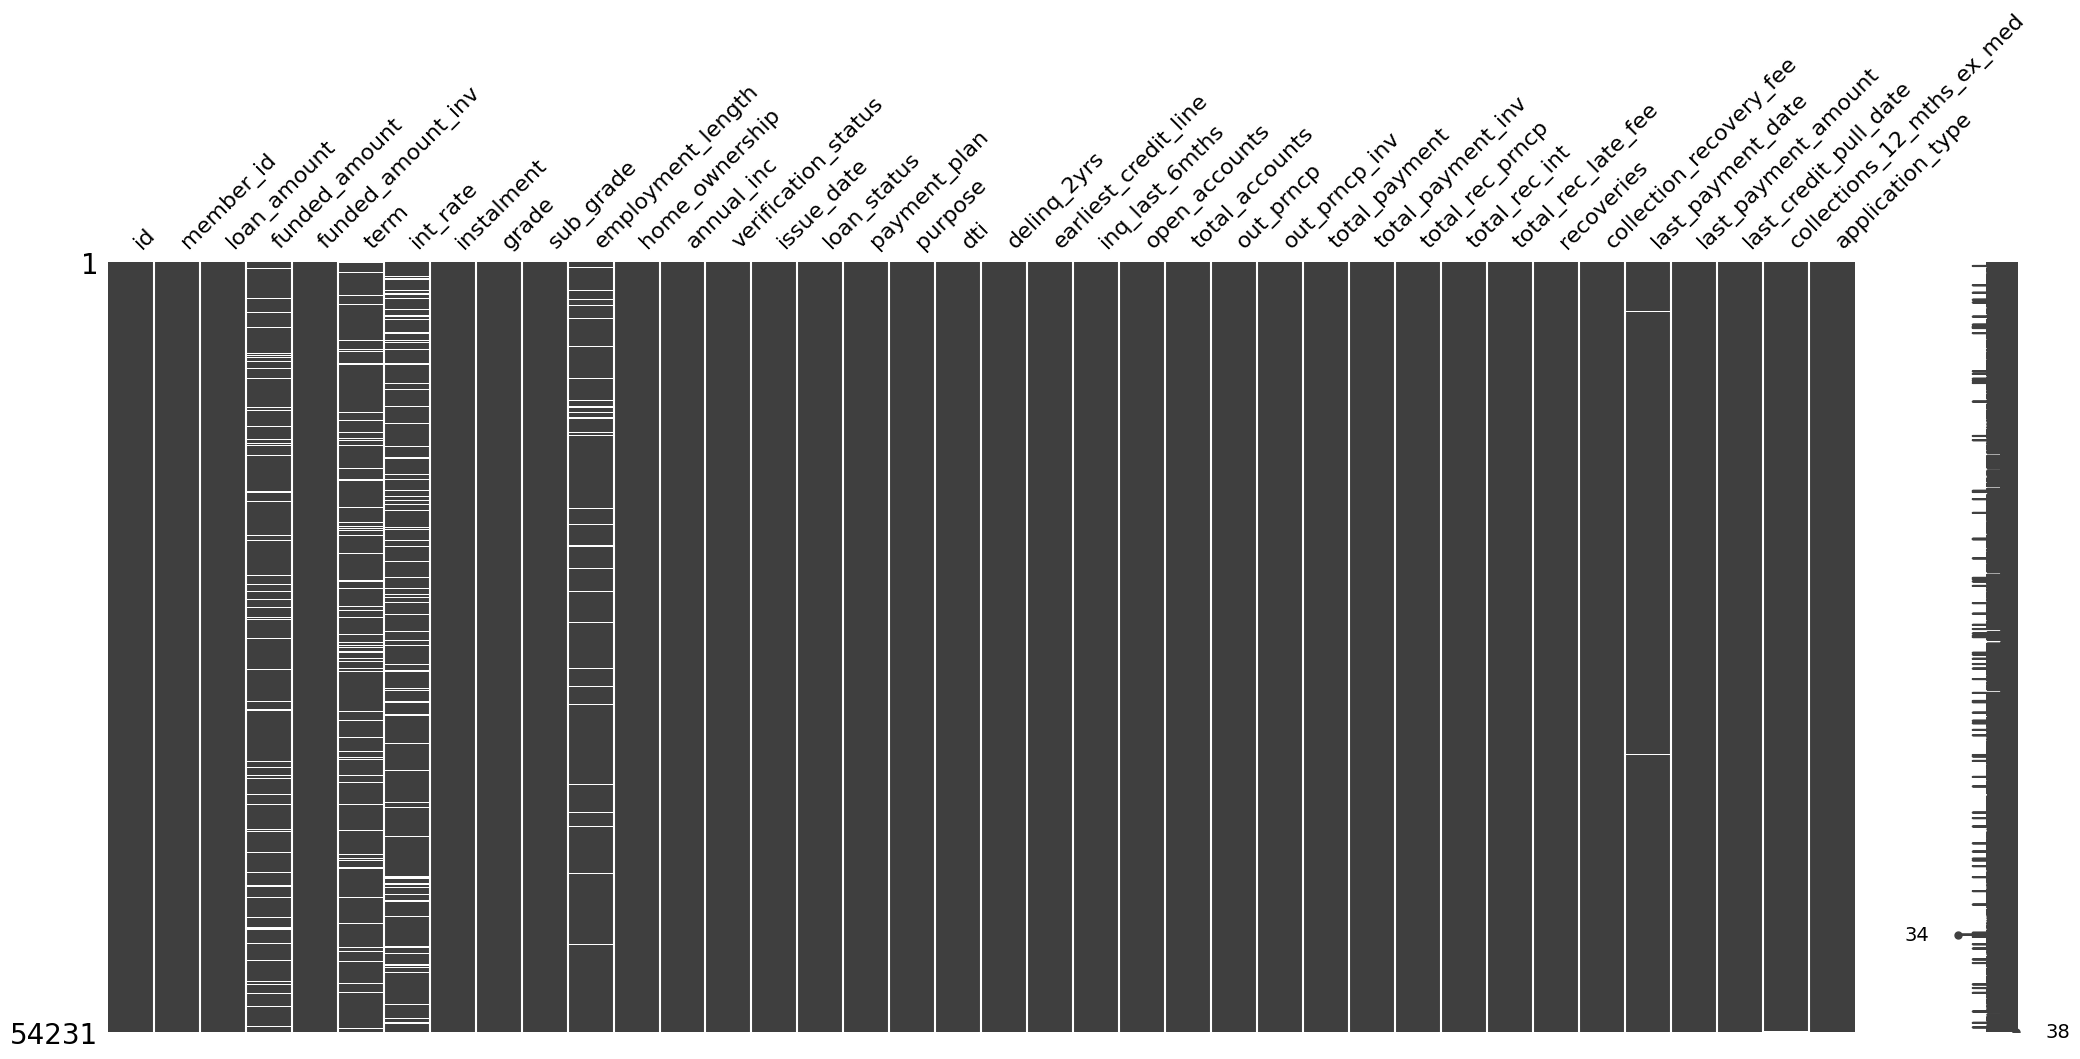

In [10]:
msno.matrix(df)

In [11]:
null_values = DataFrameInfo.percent_null(df)

print(null_values[null_values > 0], "\n\n")
print(df[null_values[null_values > 0].index].nunique()) # unique values for columns with null values

funded_amount                 5.544799
term                          8.799395
int_rate                      9.531449
employment_length             3.905515
last_payment_date             0.134609
last_credit_pull_date         0.012908
collections_12_mths_ex_med    0.094042
dtype: float64 


funded_amount                 1122
term                             2
int_rate                       457
employment_length               11
last_payment_date               98
last_credit_pull_date          101
collections_12_mths_ex_med       5
dtype: int64


we can see the "term", "employment_length", and "collections_12_mths_ex_med" are clearly categorical so lets look at their values.

In [12]:
print(
    df.term.unique(),
    df.employment_length.unique(),
    df.collections_12_mths_ex_med.unique()
)

['36 months' nan '60 months'] ['5 years' '9 years' '8 years' '1 year' '10+ years' '< 1 year' nan
 '7 years' '3 years' '4 years' '6 years' '2 years'] [ 0.  1.  2.  3.  4. nan]


lets take a closer look at the 'term' column

In [13]:
DataFrameInfo.count_values(df, 'term')


term
36 months    35845
60 months    13614
Name: count, dtype: int64

there is more 36 month terms than 60 month terms, however they seem to be relatively close, so as not to introduce any bias, i shall drop any rows with these null values.


In [14]:
DataTransform.drop_null_rows_from_columns(df, ['term'])

In [15]:
null_values = DataFrameInfo.percent_null(df)
null_values[null_values > 0]

funded_amount                 5.537920
int_rate                      9.506864
employment_length             3.879981
last_payment_date             0.135466
last_credit_pull_date         0.014153
collections_12_mths_ex_med    0.095028
dtype: float64

employment_length contains values for the customer employment length.
We should remove any null values for this column as not to introduce any bias.

In [16]:
DataTransform.drop_null_rows_from_columns(df,['employment_length'])

last_payment_date, last_credit_pull_date and collections_12_mths_ex_med have very little null values so lets just drop those rows

In [18]:
DataTransform.drop_null_rows_from_columns(df,['last_payment_date', 'last_credit_pull_date', 'collections_12_mths_ex_med'])